## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "scripts", "00")
cd(ProjDir)

Import the dataset.

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
data = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Show the first six rows of the dataset.

In [4]:
first(data, 6)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [5]:
n = size(data, 1)
test_ind = sample(1:n, Int(floor(0.3*n)), replace=false);
train_ind = [(i) for i=1:n if !(i in test_ind)];
test = data[test_ind, :];
train = data[train_ind, :];

Save dataframe versions of our dataset.

In [6]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,148.285,38.4419,39.0,0
2,147.32,40.8516,64.0,0
3,140.335,37.4497,22.0,0
4,157.48,45.8695,41.0,1
5,153.67,44.2252,26.0,0
6,161.3,43.3,20.0,1
7,160.02,49.2714,23.0,1
8,146.05,37.5064,53.0,0
9,139.7,50.3487,38.0,1


Create our labels. These are the values we are trying to predict.

In [7]:
train_label = train[:, :height]
test_label = test[:, :height]

105-element Array{Union{Missing, Float64},1}:
 148.2852
 147.32  
 140.335 
 157.48  
 153.67  
 161.3   
 160.02  
 146.05  
 139.7   
 170.18  
   ⋮     
 161.29  
 150.495 
 148.59  
 152.4   
 152.4   
 146.05  
 146.4   
 163.195 
 155.575 

Get the list of columns to keep.

In [8]:
remove_names = filter(x->!in(x, [:height, :age, :male]), names(data))

1-element Array{Symbol,1}:
 :weight

Filter the test and train sets.

In [9]:
train = Matrix(train[:, remove_names]);
test = Matrix(test[:, remove_names]);

A handy helper function to rescale our dataset.

In [10]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [11]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [12]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [13]:
dmat = [ones(size(train, 1)) train]

247×2 Array{Float64,2}:
 1.0   0.422246
 1.0  -1.35604 
 1.0  -2.08069 
 1.0   1.24026 
 1.0  -0.604713
 1.0   1.62259 
 1.0   1.46699 
 1.0   0.746783
 1.0  -0.613605
 1.0  -1.42717 
 ⋮             
 1.0  -0.173479
 1.0   0.431138
 1.0  -0.89813 
 1.0  -0.640279
 1.0   0.297767
 1.0  -1.70725 
 1.0   1.10244 
 1.0   1.4003  
 1.0   1.16023 

Bayesian linear regression.

In [14]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [15]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat);


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [16]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -52.6481, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is -53.3866, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/scripts/00/tmp/linear_regression.stan' at line 21)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[-0.0249281 0.800291 0.654064; -0.0088913 0.740482 0.657449; … ; -0.0935784 0.756108 0.689014; 0.0833384 0.791679 0.681802]

Union{Missing, Float64}[-0.00377373 0.712418 0.610491; 0.0412673 0.755905 0.630341; … ; -0.00449369 0.704531 0.690159; 0.00473048 0.744908 0.633098]

Union{Missing, Float64}[-0.00354983 0.751058 0.635974; 0.0252332 0.779152 0.657645; … ; -0.0071647 0.725201 0.712582; 0.0286703 0.729912 0.674964]

Union{Missing, Float64}[0.0937545 0.702279 0.67611; 0.0893076 0.684875 0.69887; … ; 0.030317 0.738137 0.701427; -0.0392292 0.70624 0.614061]

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean          SD        Naive SE        MCSE      ESS
intercept -0.0007731511 0.042246484 0.00066797556 0.00067228447 1000
  beta[1]  0.7525936870 0.042632749 0.00067408294 0.00069626307 1000
    sigma  0.6612759748 0.029731345 0.00047009384 0.00051401387 1000

Quantiles:
              2.5%         25.0%        50.0%        75.0%      97.5%  
intercept -0.080450278 -0.030316175 -0.0007340035 0.02796975 0.08151916
  beta[1]  0.665800175  0.725103750  0.7533205000 0.78181100 0.83381073
    sigma  0.606682875  0.640801750  0.6601925000 0.68074825 0.72249527



Perform multivariate OLS.

In [18]:
ols = lm(@formula(height ~ weight), train_cut)

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: height ~ 1 + weight

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   112.781   2.35911 47.8068   <1e-99
weight       0.928265 0.0517581 17.9347   <1e-45


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Symbol,StatsModels.ContrastsMatrix}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:2]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

Show the first side rows of the modified dataframe.

In [22]:
remove_names = filter(x->!in(x, [:age, :male]), names(test_cut));
test_cut = test_cut[remove_names];
first(test_cut, 6)

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.height).^2);
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.height).^2);

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.height).^2);
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.height).^2);

println("\nTraining set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")


Training set:
  Bayes loss: 6565.502531634431
  OLS loss: 6565.483143726995
Test set:
  Bayes loss: 2471.0822849173533
  OLS loss: 2498.1784018291373


Plot the chains.

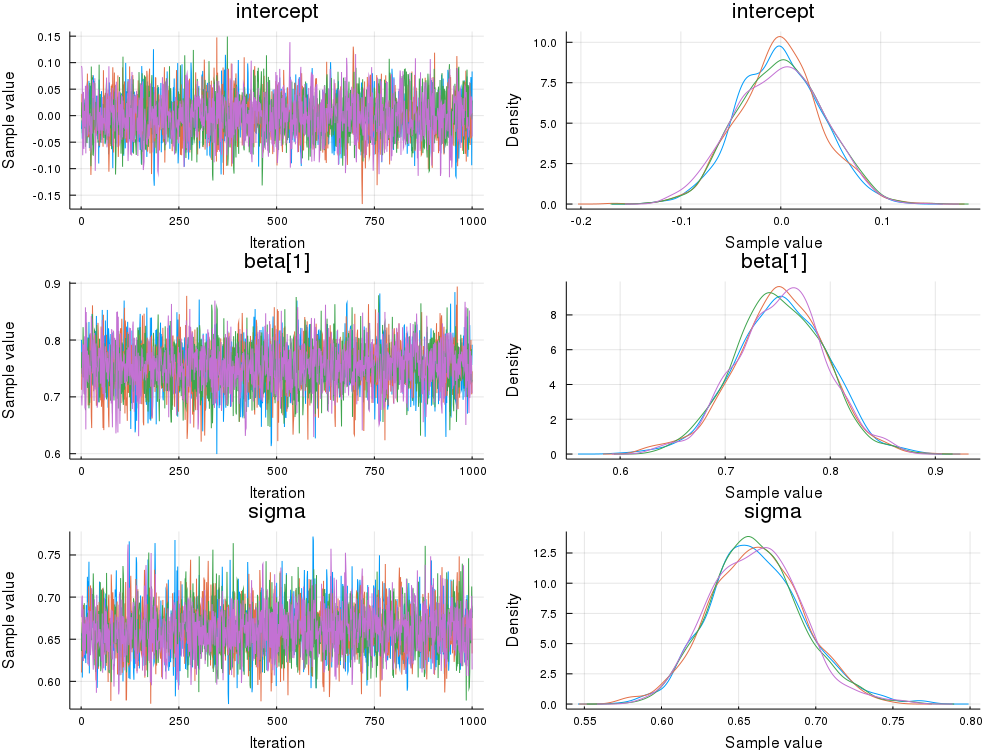

In [23]:
plot(chain)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*